In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
git 

In [76]:
os.chdir(r'c:\Users\karina mehta\UVA class\UnderstandingUncertainity\git_practice\group_git\snp_data')

In [77]:
sp_comp = pd.read_csv('sp500_companies.csv')
sp_index = pd.read_csv('sp500_index.csv')
sp_stocks = pd.read_csv('sp500_stocks.csv')

### Markov Chain

How likely will it be a bearish/bullish day

#### Individual Stock level

In [78]:
sp_stocks.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
1891531,2024-12-16,ZTS,175.809998,175.809998,179.289993,175.789993,177.990005,1938800.0
1891532,2024-12-17,ZTS,170.789993,170.789993,177.320007,169.520004,175.000000,3018300.0
1891533,2024-12-18,ZTS,167.009995,167.009995,170.940002,166.899994,170.070007,2728300.0
1891534,2024-12-19,ZTS,163.520004,163.520004,167.440002,163.369995,166.589996,3713700.0
1891535,2024-12-20,ZTS,164.839996,164.839996,166.389999,163.529999,163.759995,6220100.0


In [79]:
sp_stocks = sp_stocks.sort_values(['Date','Symbol'])
#Percent Change of Adj Close from previous day to the next day for each stock
sp_stocks['pct_change'] = sp_stocks.groupby('Symbol')['Adj Close'].pct_change()
#First row will return NaN since there is no previous day to compare 
sp_stocks = sp_stocks.dropna(subset=['pct_change'])


C:\Users\karina mehta\AppData\Local\Temp\ipykernel_16760\1342530805.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp_stocks['pct_change'] = sp_stocks.groupby('Symbol')['Adj Close'].pct_change()


In [80]:
# Creating state of 'bear' and 'bull'
# Bear: Market is down i.e. negative change
# Bull: Market is up i.e. positive change

# sp_stocks['State'] = sp_stocks['pct_change'].apply(lambda x: 'Bull' if x > 1 else 'Bear')

threshold = 0.001

def classify_change(x):
    if x > threshold:
        return 'Bull'
    elif x < -threshold:
        return 'Bear'
    else:
        return 'Stable'
    
sp_stocks['State'] = sp_stocks['pct_change'].apply(classify_change)



In [81]:
sp_stocks['State'].value_counts(normalize=True)

State
Bull      0.491902
Bear      0.440697
Stable    0.067401
Name: proportion, dtype: float64

In [82]:
#Individual Markov chain according to each symbol/ticker
train = sp_stocks[sp_stocks['Date'] < '2020-01-01']


ticker = train['Symbol'].unique()
transition_matrices = {}

for t in ticker:
    ticker_state = train[train['Symbol'] == t].sort_values('Date')['State'].values
    transition_matrices[t] = pd.crosstab(ticker_state[:-1], ticker_state[1:], normalize='index')


In [83]:
transition_matrices['AAPL']

col_0,Bear,Bull,Stable
row_0,,,
Bear,0.442818,0.494053,0.063129
Bull,0.431655,0.498002,0.070344
Stable,0.405882,0.517647,0.076471


### Sector-Level Analysis

In [84]:
#Creating a dataframe for each sector names and marketcap and weight according to symbols and their states
sp_sector = train.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [85]:
sp_sector.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
0,2010-01-05,A,19.835201,22.145924,22.331903,22.002861,22.324751,4186031.0,-0.010863,Bear,Healthcare,38415384576,0.000691
1,2010-01-05,AAPL,6.458560,7.656429,7.699643,7.616071,7.664286,601904800.0,0.001729,Bull,Technology,3846819807232,0.069209
2,2010-01-05,ABT,18.612120,25.918797,26.134706,25.789249,26.134706,10562109.0,-0.008079,Bear,Healthcare,198127370240,0.003565
3,2010-01-05,ACGL,7.967778,7.967778,7.995556,7.910000,7.942222,3807000.0,-0.003336,Bear,Financial Services,34234257408,0.000616
4,2010-01-05,ACN,33.174648,42.330002,42.450001,41.980000,42.099998,2613000.0,0.006181,Bull,Technology,229157109760,0.004123


In [86]:
sector_groups = sp_sector[['Symbol','Sector']].drop_duplicates()

In [87]:
# Unique sectors
sectors = sector_groups['Sector'].unique()
sector_transitions = {}

for sector in sectors:

    # Going through the tickers in each sector
    symbol_sector = sector_groups[sector_groups['Sector'] == sector]['Symbol']
    # Creating a list for matrics and weights for each sector
    matrics, weights = [], []

    # Going through the tickers in each sector
    for t in symbol_sector:

        # Going through the transition matrices for each of the tickers
        if t in transition_matrices:
            # Adding the transition matrix of the ticker to the sector list
            matrics.append(transition_matrices[t])
            # Adding the weight of the ticker to the sector list
            weight = sp_comp.loc[sp_comp['Symbol'] == t, 'Marketcap'].values[0]
            weights.append(weight)

    if matrics:

        matrics = [m.values if isinstance(m, pd.DataFrame) else m for m in matrics]

        #Weighted_sum of the matrics and weights
        weighted_sum = sum(m*w for m,w in zip(matrics, weights))
        #Averaging out the weighted sum
        avg_matrix = weighted_sum / sum(weights)
        #Adding the transition matrix of each sector to a dictionary
        sector_transitions[sector] = avg_matrix

In [88]:
sector_transitions['Financial Services']

array([[0.41190518, 0.51949813, 0.06859669],
       [0.45300593, 0.46782848, 0.07916559],
       [0.43826   , 0.47576704, 0.08597296]])

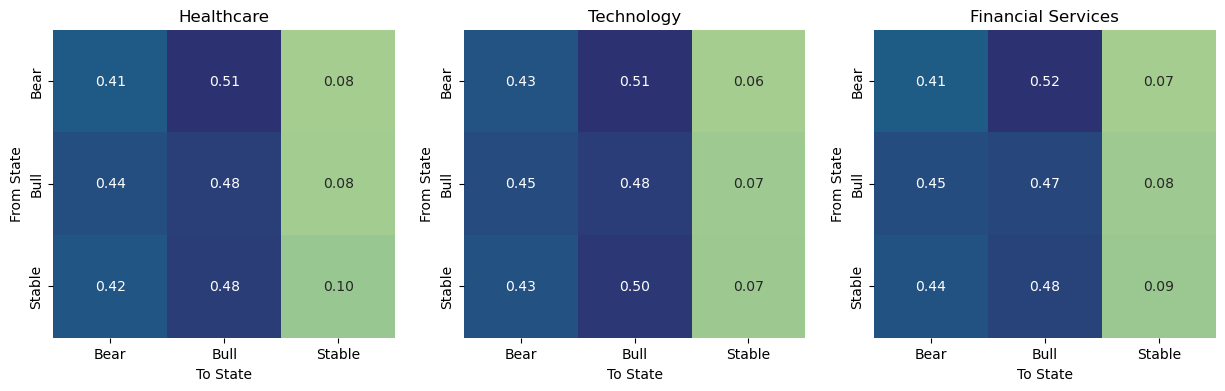

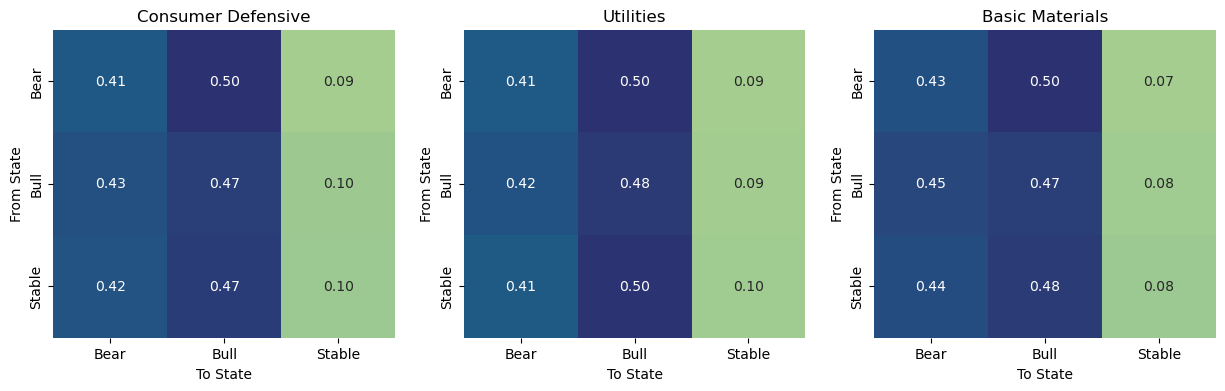

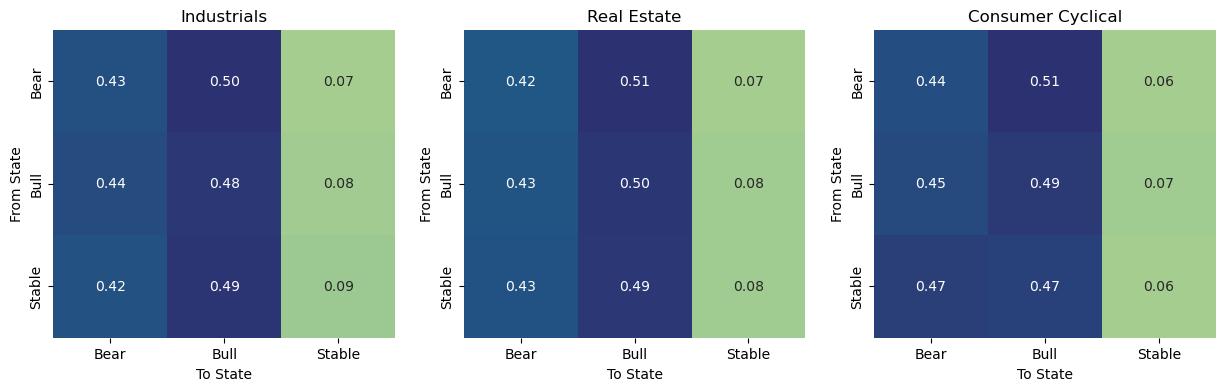

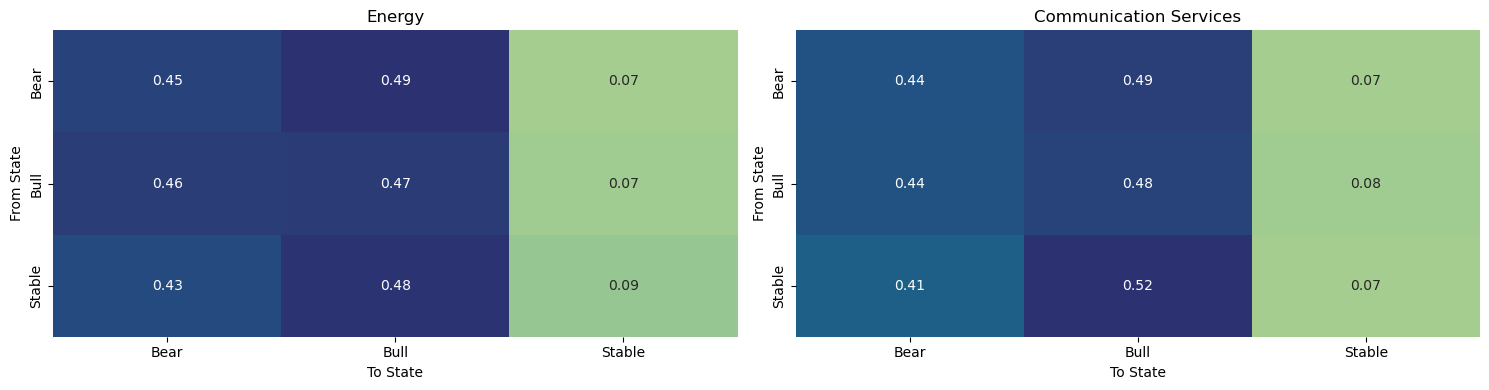

In [89]:
sectors_per_plot = 3

for i in range(0,len(sectors),sectors_per_plot):
    selected = sectors[i:i+sectors_per_plot]

    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))

    for ax, sector in zip(axes, selected):
        matrix = sector_transitions[sector]
        sns.heatmap(matrix, annot=True, cmap='crest', cbar=False, fmt='.2f', ax=ax,
                    xticklabels=['Bear','Bull','Stable'], yticklabels=['Bear','Bull','Stable'])
        ax.set_title(sector)
        ax.set_xlabel('To State')
        ax.set_ylabel('From State')

plt.tight_layout()
plt.show()

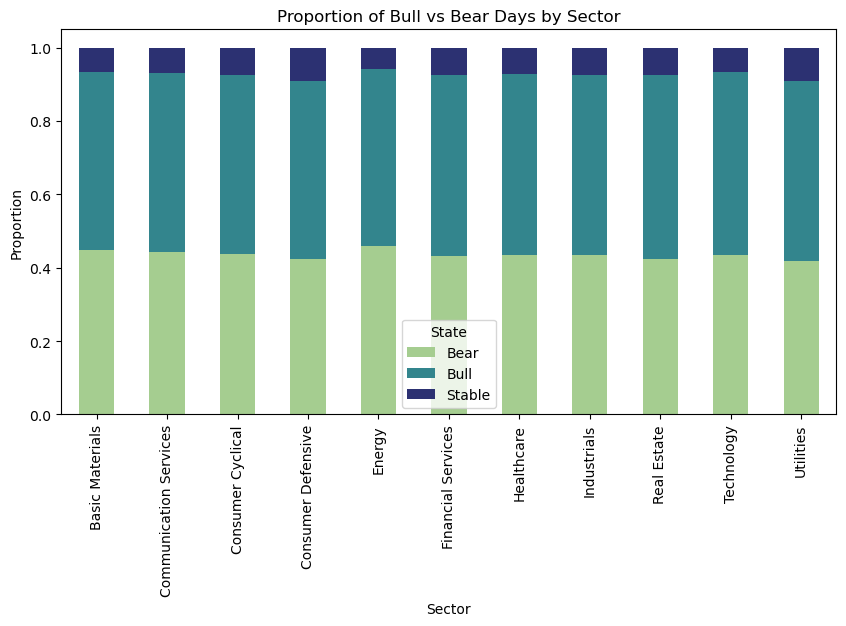

In [90]:
state_counts = (
    sp_sector.groupby(['Sector', 'State'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
)

state_counts.plot(kind='bar', stacked=True, figsize=(10,5), colormap='crest')
plt.title('Proportion of Bull vs Bear Days by Sector')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.show()


### Simulation on Test Model

In [110]:
sp_stocks

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State
33913,2010-01-05,A,19.835201,22.145924,22.331903,22.002861,22.324751,4186031.0,-0.010863,Bear
146953,2010-01-05,AAPL,6.458560,7.656429,7.699643,7.616071,7.664286,601904800.0,0.001729,Bull
7537,2010-01-05,ABT,18.612120,25.918797,26.134706,25.789249,26.134706,10562109.0,-0.008079,Bear
158257,2010-01-05,ACGL,7.967778,7.967778,7.995556,7.910000,7.942222,3807000.0,-0.003336,Bear
15073,2010-01-05,ACN,33.174648,42.330002,42.450001,41.980000,42.099998,2613000.0,0.006181,Bull
...,...,...,...,...,...,...,...,...,...,...
1876463,2024-12-20,XYL,117.139999,117.139999,118.120003,115.900002,116.070000,2799600.0,0.006098,Bull
1880231,2024-12-20,YUM,132.360001,132.360001,133.380005,130.139999,130.250000,3212900.0,0.015342,Bull
1887767,2024-12-20,ZBH,107.120003,107.120003,107.779999,105.339996,105.339996,3969100.0,0.012381,Bull
1883999,2024-12-20,ZBRA,393.040009,393.040009,395.029999,382.850006,383.350006,826400.0,0.019903,Bull


In [113]:
test  = sp_stocks[sp_stocks['Date'] >= '2020-01-01']

test = test.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [114]:
test.tail()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
620452,2024-12-20,XYL,117.139999,117.139999,118.120003,115.900002,116.070000,2799600.0,0.006098,Bull,Industrials,28458575872,0.000512
620453,2024-12-20,YUM,132.360001,132.360001,133.380005,130.139999,130.250000,3212900.0,0.015342,Bull,Consumer Cyclical,36937969664,0.000665
620454,2024-12-20,ZBH,107.120003,107.120003,107.779999,105.339996,105.339996,3969100.0,0.012381,Bull,Healthcare,21324808192,0.000384
620455,2024-12-20,ZBRA,393.040009,393.040009,395.029999,382.850006,383.350006,826400.0,0.019903,Bull,Technology,20273004544,0.000365
620456,2024-12-20,ZTS,164.839996,164.839996,166.389999,163.529999,163.759995,6220100.0,0.008072,Bull,Healthcare,74370031616,0.001338


In [115]:
import random

def simulate_sector(start_state, transition_matrix, days):
    states = ['Bear','Bull','Stable']
    sequence = [start_state]
    for _ in range(days-1):
        probs = transition_matrix.loc[sequence[-1]].values
        next_state = random.choices(states, weights=probs, k=1)[0]
        sequence.append(next_state)
    return sequence

# Dictionary to store simulated sector states
simulated_sector_states = {}

for sector in sectors:
    # Starting state: last state from training data
    last_state = train[train['Sector']==sector].sort_values('Date')['State'].iloc[-1]
    
    # Number of days to simulate: unique dates in test for this sector
    days = test[test['Sector']==sector]['Date'].nunique()
    
    # Simulate sequence
    simulated_sector_states[sector] = simulate_sector(last_state, sector_transitions[sector], days)

# Compare simulated vs actual
for sector in sectors:
    sim_counts = pd.Series(simulated_sector_states[sector]).value_counts(normalize=True)
    actual_counts = actual_states[actual_states['Sector']==sector]['State'].value_counts(normalize=True)
    
    print(f"\nSector: {sector}")
    print("Simulated:", sim_counts.to_dict())
    print("Actual   :", actual_counts.to_dict())



Sector: Healthcare
Simulated: {'Bull': 0.46884984025559107, 'Bear': 0.43610223642172524, 'Stable': 0.0950479233226837}
Actual   : {'Bull': 0.5103833865814696, 'Bear': 0.48961661341853036}

Sector: Technology
Simulated: {'Bull': 0.4712460063897764, 'Bear': 0.4544728434504792, 'Stable': 0.0742811501597444}
Actual   : {'Bull': 0.5303514376996805, 'Bear': 0.4696485623003195}

Sector: Financial Services
Simulated: {'Bull': 0.48003194888178913, 'Bear': 0.4496805111821086, 'Stable': 0.07028753993610223}
Actual   : {'Bull': 0.5311501597444089, 'Bear': 0.46884984025559107}

Sector: Consumer Defensive
Simulated: {'Bull': 0.481629392971246, 'Bear': 0.4257188498402556, 'Stable': 0.0926517571884984}
Actual   : {'Bull': 0.5207667731629393, 'Bear': 0.4792332268370607}

Sector: Utilities
Simulated: {'Bull': 0.4904153354632588, 'Bear': 0.4233226837060703, 'Stable': 0.08626198083067092}
Actual   : {'Bull': 0.5287539936102237, 'Bear': 0.4712460063897764}

Sector: Basic Materials
Simulated: {'Bull': 0.47

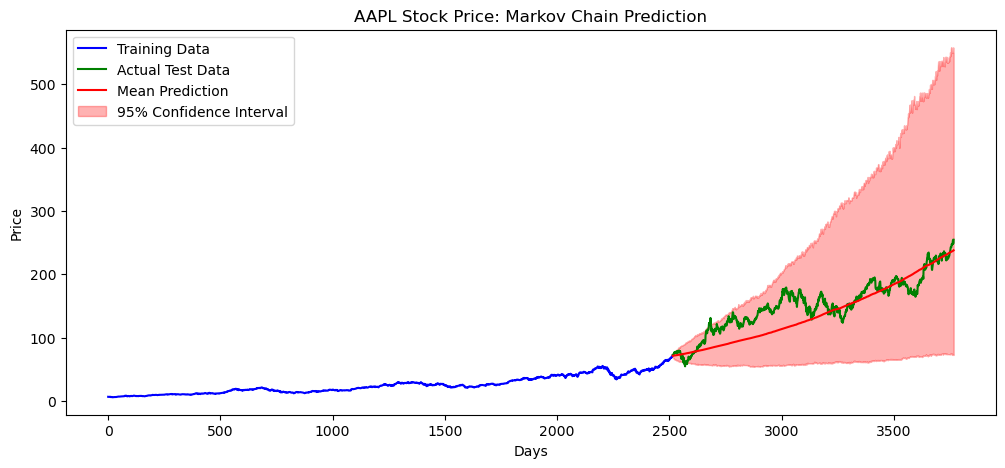

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Example for a single stock/sector
states = ['Bear', 'Bull', 'Stable']
state_to_return = {'Bear': -0.015, 'Stable': 0, 'Bull': 0.015}  # example daily return

# Get the last state from training as starting point
last_state = train[train['Symbol']=='AAPL'].iloc[-1]['State']
transition_matrix = transition_matrices['AAPL']  # or sector_transitions['Financial Services']

n_days = len(test[test['Symbol']=='AAPL'])
simulations = 1000  # number of simulations for CI
simulated_prices = np.zeros((simulations, n_days))

initial_price = train[train['Symbol']=='AAPL'].iloc[-1]['Adj Close']

for i in range(simulations):
    price = initial_price
    state = last_state
    for day in range(n_days):
        # Choose next state based on transition probabilities
        probs = transition_matrix.loc[state].values
        state = np.random.choice(states, p=probs)
        # Convert state to price change
        price *= 1 + state_to_return[state]
        simulated_prices[i, day] = price

# Compute mean and 95% CI
mean_pred = simulated_prices.mean(axis=0)
lower = np.percentile(simulated_prices, 2.5, axis=0)
upper = np.percentile(simulated_prices, 97.5, axis=0)

# Actual test prices
actual_prices = test[test['Symbol']=='AAPL']['Adj Close'].values
train_prices = train[train['Symbol']=='AAPL']['Adj Close'].values

# Plot
plt.figure(figsize=(12,5))
plt.plot(range(len(train_prices)), train_prices, color='blue', label='Training Data')
plt.plot(range(len(train_prices), len(train_prices)+len(actual_prices)), actual_prices, color='green', label='Actual Test Data')
plt.plot(range(len(train_prices), len(train_prices)+len(actual_prices)), mean_pred, color='red', label='Mean Prediction')
plt.fill_between(range(len(train_prices), len(train_prices)+len(actual_prices)), lower, upper, color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('AAPL Stock Price: Markov Chain Prediction')
plt.legend()
plt.show()
